## Predicting Rainfall in Vancouver

### Introduction

Being one of the rainiest cities in all of Canada, Vancouver averages over 1 metre of rainfall per year (Government of Canada 1981-2010 Climate Normals & Averages). Daily weather forecasts have become essential for residents, from planning what to wear to figuring out their activities for the following day, expressing a great appreciation for forecasts used by meteorologists. Meteorologists use complex computations based on Lewis Richardson's numerical process for weather prediction (1922). However, a [2021 study by Colorado State University](https://source.colostate.edu/ai-and-machine-learning-are-improving-weather-forecasts-but-they-wont-replace-human-experts/#:~:text=Some%20studies%20have%20shown%20that,computing%20power%20the%20models%20require.) showed that machine-learning-based forecast systems could predict the weather just as well, but at a fraction of the cost, lowering the amount of resources required. This further leads us to question if it is possible to predict how much it would rain on any given day of the year. 
This project aims to explore this through the use of meteorological measurements such as temperature, relative humidity, time of the year, and windspeed with a regression model to predict rainfall amounts. This model will be trained using a [dataset](https://vancouver.weatherstats.ca/download.html) downloaded from Vancouver Weather Stats, containing climate data for Vancouver for the past decade (2011-2021).

### Preliminary Data Analysis

Our first step is to load, wrangle, and explore the data visualizations. We start by loading the five below packages (`tidyverse`,`haven`,`lubridate`,`tidymodels`,`cowplot`) needed for our analysis.

In [1]:
## needed packages
library(tidyverse)
library(haven)
library(lubridate)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   mask

From [this website](https://vancouver.weatherstats.ca/download.html) we downloaded the dataset of the daily weather in Vancouver for the past decade, which is a `.csv` file with headers. We’ll use the `read_csv()` function to load the data and assign it to an object called `weather`. We will also filter the dataset for observations between 2001 to 2021 (inclusive), because the dataset isn't complete for values outside that range.

In [2]:
weather <- read_csv("https://raw.githubusercontent.com/taimagher/Weather-Stats-Report/main/weatherstats_vancouver_daily_2001.csv") |>
            filter(year(date) >= 2011 & year(date) <= 2021) |>
            arrange(date)

Rows: 4400 Columns: 70
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (62): max_temperature, avg_hourly_temperature, avg_temperature, min_tem...
lgl   (5): solar_radiation, max_cloud_cover_4, avg_hourly_cloud_cover_4, avg...
date  (1): date
time  (2): sunrise, sunset

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Then, we use `slice()` to preview the first 6 rows of our data for further improving.

In [3]:
weather |> tail(6)
weather |> head(6)

date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,⋯,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-12-26,-5.7,-7.70,-8.25,-10.8,NA,-16,90,72.5,72.5,⋯,NA,NA,8,6.7,4.5,1,NA,NA,NA,NA
2021-12-27,-7.8,-10.80,-11.55,-15.3,NA,-23,85,67.9,71.0,⋯,NA,NA,8,6.1,4.0,0,NA,NA,NA,NA
2021-12-28,-4.4,-8.05,-8.60,-12.8,NA,-20,91,80.9,79.0,⋯,NA,NA,8,5.3,4.0,0,NA,NA,NA,NA
2021-12-29,-4.1,-7.09,-7.90,-11.7,NA,-18,92,69.2,70.0,⋯,NA,NA,8,4.6,4.0,0,NA,NA,NA,NA
2021-12-30,-0.7,-4.03,-4.39,-8.1,NA,-14,94,85.0,80.0,⋯,NA,NA,8,4.6,4.5,1,NA,NA,NA,NA
2021-12-31,-2.5,-6.64,-6.70,-10.9,NA,-17,93,74.8,72.5,⋯,NA,NA,8,3.5,4.5,1,NA,NA,NA,NA


date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,⋯,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-01-01,3.3,-1.62,-1.55,-6.4,NA,-10,92,76.1,74.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2011-01-02,3.4,-1.08,-1.30,-6.0,NA,-8,95,82.6,81.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2011-01-03,4.3,-0.44,-0.30,-4.9,NA,-8,95,86.4,82.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2011-01-04,3.1,1.22,0.50,-2.1,NA,-6,93,87.0,83.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2011-01-05,5.7,3.39,3.55,1.4,NA,NA,95,92.6,92.0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2011-01-06,6.8,5.63,5.75,4.7,NA,NA,96,94.2,94.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


We observed that there are columns containing maximum and minimum readings recorded for each day. We do not need these columns, since it is not reasonable to train our model on extreme values (they could contain outliers). We shall thus use `select` function to extract the columns `date` and those that start with `avg_*`, as well as `rain` that we needed.

In [4]:
selected_rain_data <- weather |>
                    select(date, starts_with('avg'), rain) 

There are also some rows for `rain` that contain `NA`s which we must filter out. Otherwise, our regression algorithm can unintentionally predict `NA` due to an `NA` value when calculating the mean value of nearest neighbors. To avoid this, we need to add the argument `is.na() == FALSE` as illustrated below.

In [5]:
rain_data <- selected_rain_data |>
                    filter(is.na(rain) == FALSE)

Before we proceed, let us first split our data into training and testing using `initial_split` function to ensure fairness when testing accuracy. We have chosen to allocate **75%** of the data for training. This ensures balance between enough data available a well-trained model, as well as enough data to judge the accuracy well. We maintain evenness of the `rain` column's values when splitting (here, set `strata` to `rain`. We also set a seed in **78** so that our split is reproducible when we move on to actually implementing the algorithm.

In [6]:
set.seed(78)

rain_split <- initial_split(rain_data, prop = 0.75, strata = rain)
rain_training <- training(rain_split)
rain_testing <- testing(rain_split)

We can then use `group_by` and `summarize` as well as `sum()` to find the Total Rainfall of each year(2012-2021) in `rain_training`. From here on out, we will only use training data until our testing phase. This is to abide by the golden rule of machine learning. 

In [7]:
total_rain_year <- rain_training |> 
                    group_by(year(date)) |>
                    summarize(sum(rain))
colnames(total_rain_year) <- c("Year", "Total Rainfall (mm)")
total_rain_year

Year,Total Rainfall (mm)
<dbl>,<dbl>
2011,804.4
2012,799.3
2013,670.2
2014,998.2
2015,767.8
2016,923.4
2017,863.0
2018,977.0
2019,619.2


###### *Table 1: Rain Training model from years 2012-2021*


This table shows us how significant rainfall amounts in Vancouver are, and that they have been consistent over time. We will now move on to identifying predictors to choose for our model.

### Choosing Predictors

We want to predict`Rainfall`(in mm) given a particular day of the year`Date`. But we know that rain changes seasonally. Thus, to confirm this, we first plot a scatterplot using `geom_point()` (with _only_ training data) with the `Date` on the _x_-axis and the `Rainfall` in millimetres on the _y_-axis to assess the relationship between these two variables, shown in *Figure 1.0*.

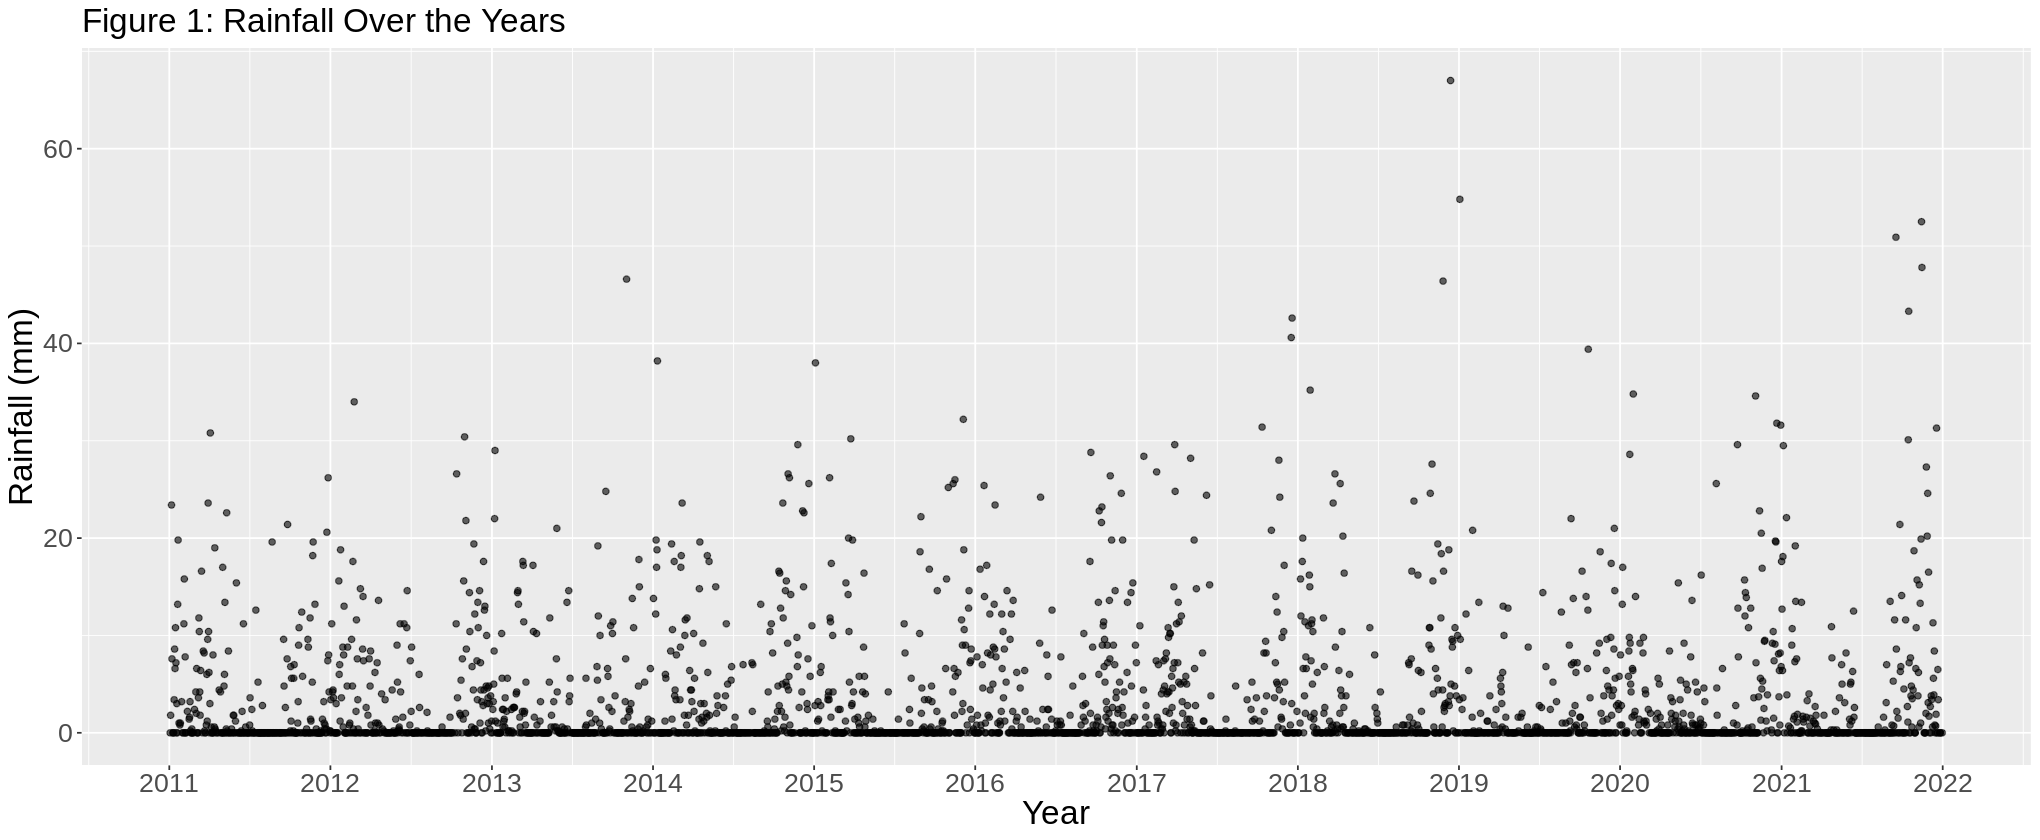

In [92]:
options(repr.plot.width = 17, repr.plot.height = 7)

rain_over_time_plot <- ggplot(rain_training, aes(x = date, y = rain)) + 
                        geom_point(alpha = 0.6) + 
                        labs(x = "Year", y = "Rainfall (mm)", subtitle = "Figure 1: Rainfall Over the Years") +
                        scale_x_date(date_labels = "%Y", date_breaks = "1 year") +
                        theme(text = element_text(size = 20))
                     
rain_over_time_plot

We can confirm from the above plot that the rainfall does indeed follow a seasonal pattern, dropping around the middle of each calendar year. It is evident that the actual time within the year is useful when predicting rainfall. 
Let us add a new column called `yday`, which gives a value from 0 to 366 (based on day of the year) for each of our observations. For example, January 1st would have a `yday` of 1, February 3rd would have a `yday` of 34, etc. There is a useful function `yday` from the `lubridate` that does this converstion for us, appropriately handling leap years too.

In [37]:
rain_training <- rain_training |> mutate(yday = yday(date))
rain_testing <- rain_testing |> mutate(yday = yday(date))

Let us take a look at the variation of rainfall against this predictor.

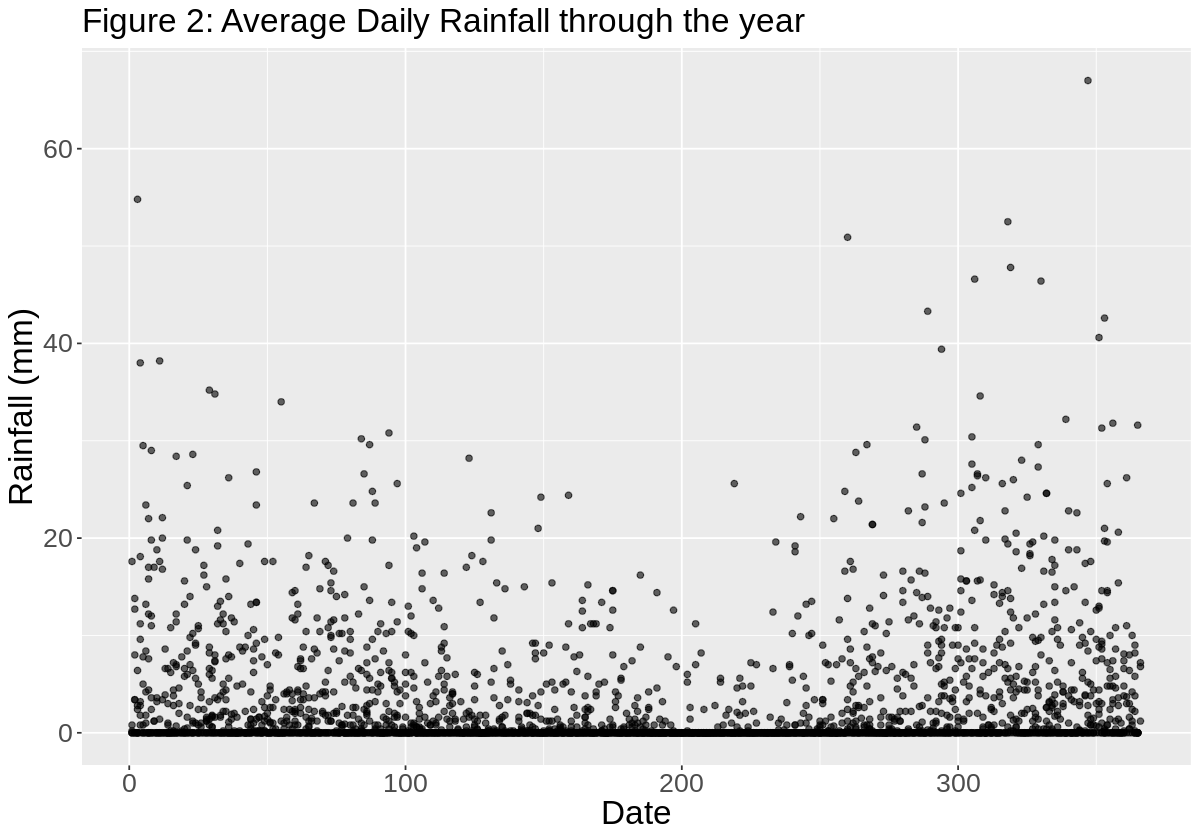

In [41]:
options(repr.plot.width = 10, repr.plot.height = 7)

rain_yday_plot <- ggplot(rain_training, aes(x = yday, y = rain)) + 
                        geom_point(alpha = 0.6) + 
                        labs(x = "Date", y = "Rainfall (mm)", subtitle = "Figure 2: Average Daily Rainfall through the year") +
                        theme(text = element_text(size = 20))
                     
rain_yday_plot

It is visible from this plot that rainfall peaks at around December-January, and drops in July-August. This will be useful as a predictor for our _KNN_ model. We will now consider some meteorological predictors we can use.

According to [The National Oceanic and Atmospheric Administration](https://www.noaa.gov/education/resource-collections/weather-atmosphere/weather-observations#:~:text=Temperature%2C%20humidity%2C%20precipitation%2C%20air,first%20weather%20observations%20were%20recorded), the ‘key observations’ used to predict weather patterns are temperature, humidity, wind speed, air pressure, and wind direction. 

Since wind direction is not quantifiable, we can't use it to train our _KNN_(K-nearest neighbors) regression model. We shall then investigate how the other measurements affect rain. Let us summarize the mean value of these measurements for each day of the year using `group_by` and `summarize` as well as `mean` functions.

In [39]:
rain_summary <- rain_training |>
                group_by(yday) |>
                summarize(rain = mean(rain), 
                          avg_temperature = mean(avg_temperature),
                          avg_relative_humidity = mean(avg_temperature),
                          avg_wind_speed = mean(avg_wind_speed),
                          avg_pressure_station = mean(avg_pressure_station))

Below Figures 3-6 visualize the relationship between `rainfall` and our potential predictor measurements, `temperature`,`humidity`,`windspeed`,`pressure`.

In [50]:
options(repr.plot.width = 19, repr.plot.height = 6)

rain_temperature_plot <- ggplot(rain_training, aes(x = avg_temperature, y = rain)) + 
                         geom_point(alpha= 0.6) + 
                         labs(x = "Temperature (°C)", y = "Rainfall (mm)", subtitle = "Figure 3") +
                        theme(text = element_text(size = 20))


rain_humidity_plot <- ggplot(rain_training, aes(x = avg_relative_humidity, y = rain)) +
                      geom_point(alpha= 0.6) +
                      labs(x = "Humidity (%)", y = "Rainfall (mm)", subtitle = "Figure 4") +
                        theme(text = element_text(size = 20))

rain_windspeed_plot <- ggplot(rain_training, aes(x = avg_wind_speed, y = rain)) + 
                       geom_point(alpha= 0.6) + 
                       labs(x = "Wind Speed (km/h)", y = "Rainfall (mm)", subtitle = "Figure 5") +
                        theme(text = element_text(size = 20))

rain_pressure_plot <- ggplot(rain_training, aes(x = avg_pressure_station, y = rain)) + 
                       geom_point(alpha= 0.6) + 
                       labs(x = "Air Pressure (kPa)", y = "Rainfall (mm)", subtitle = "Figure 6") +
                        theme(text = element_text(size = 20))

Additionally, Figures 7-10 show how these predictors relate to our first predictor, the time of the year.

In [53]:
options(repr.plot.width = 19, repr.plot.height = 6)
rain_temperature_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                                   geom_bar(stat = 'identity', aes(fill = avg_temperature)) + 
                                   scale_fill_distiller(palette = 'YlOrRd') +
                                   labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Temperature (°C)", subtitle = "Figure 7") +
                                   theme(text = element_text(size = 20)) 

rain_humidity_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                                geom_bar(stat = 'identity', aes(fill = avg_relative_humidity)) + 
                                scale_fill_distiller(palette = 'Blues', direction = 1) +
                                labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Humidity (%)", subtitle = "Figure 8") +
                                theme(text = element_text(size = 20)) 

rain_windspeed_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                            geom_bar(stat = 'identity', aes(fill = avg_wind_speed)) +
                            scale_fill_distiller(palette = 'Greens') +
                            labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Wind Speed (km/h)", subtitle = "Figure 9") +
                            theme(text = element_text(size = 20))

rain_pressure_over_time_plot <- rain_summary |> ggplot(aes(x = yday, y = rain)) + 
                            geom_bar(stat = 'identity', aes(fill = avg_pressure_station)) +
                            scale_fill_distiller(palette = 'Purples') +
                            labs(x = "Day of the year", y = "Average Rainfall (mm)", fill = "Air Pressure (kPa)", subtitle = "Figure 10") +
                            theme(text = element_text(size = 20))

For a better comparison, we set the same variables side by side using `plot_grid`.

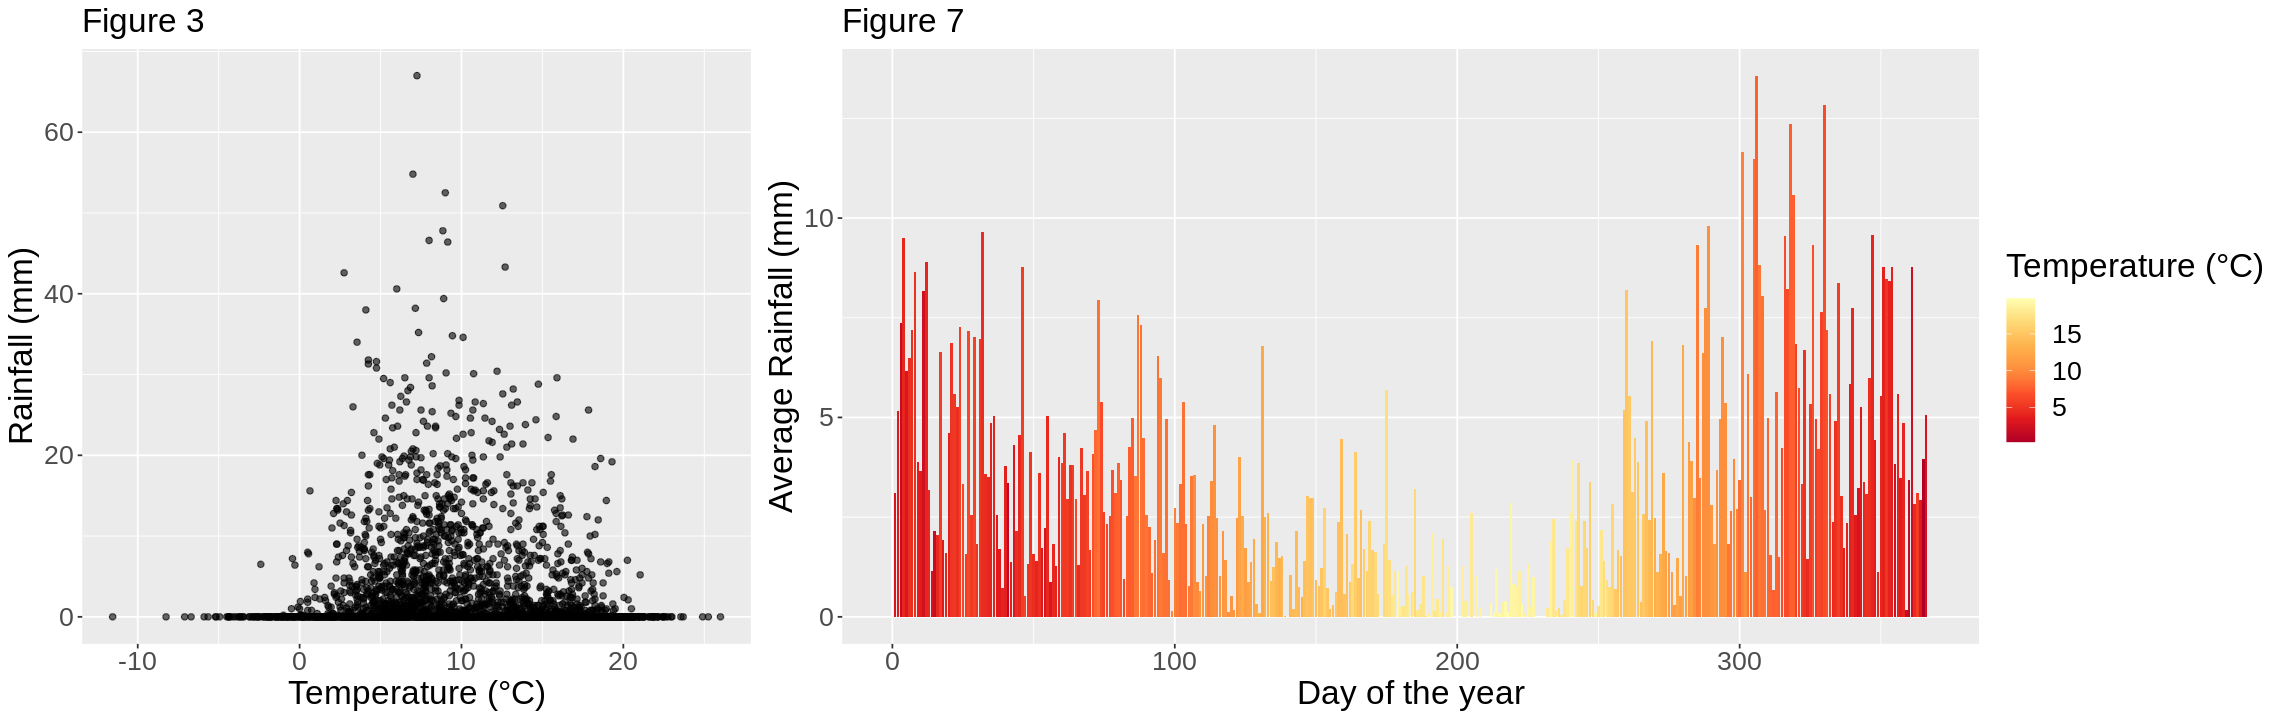

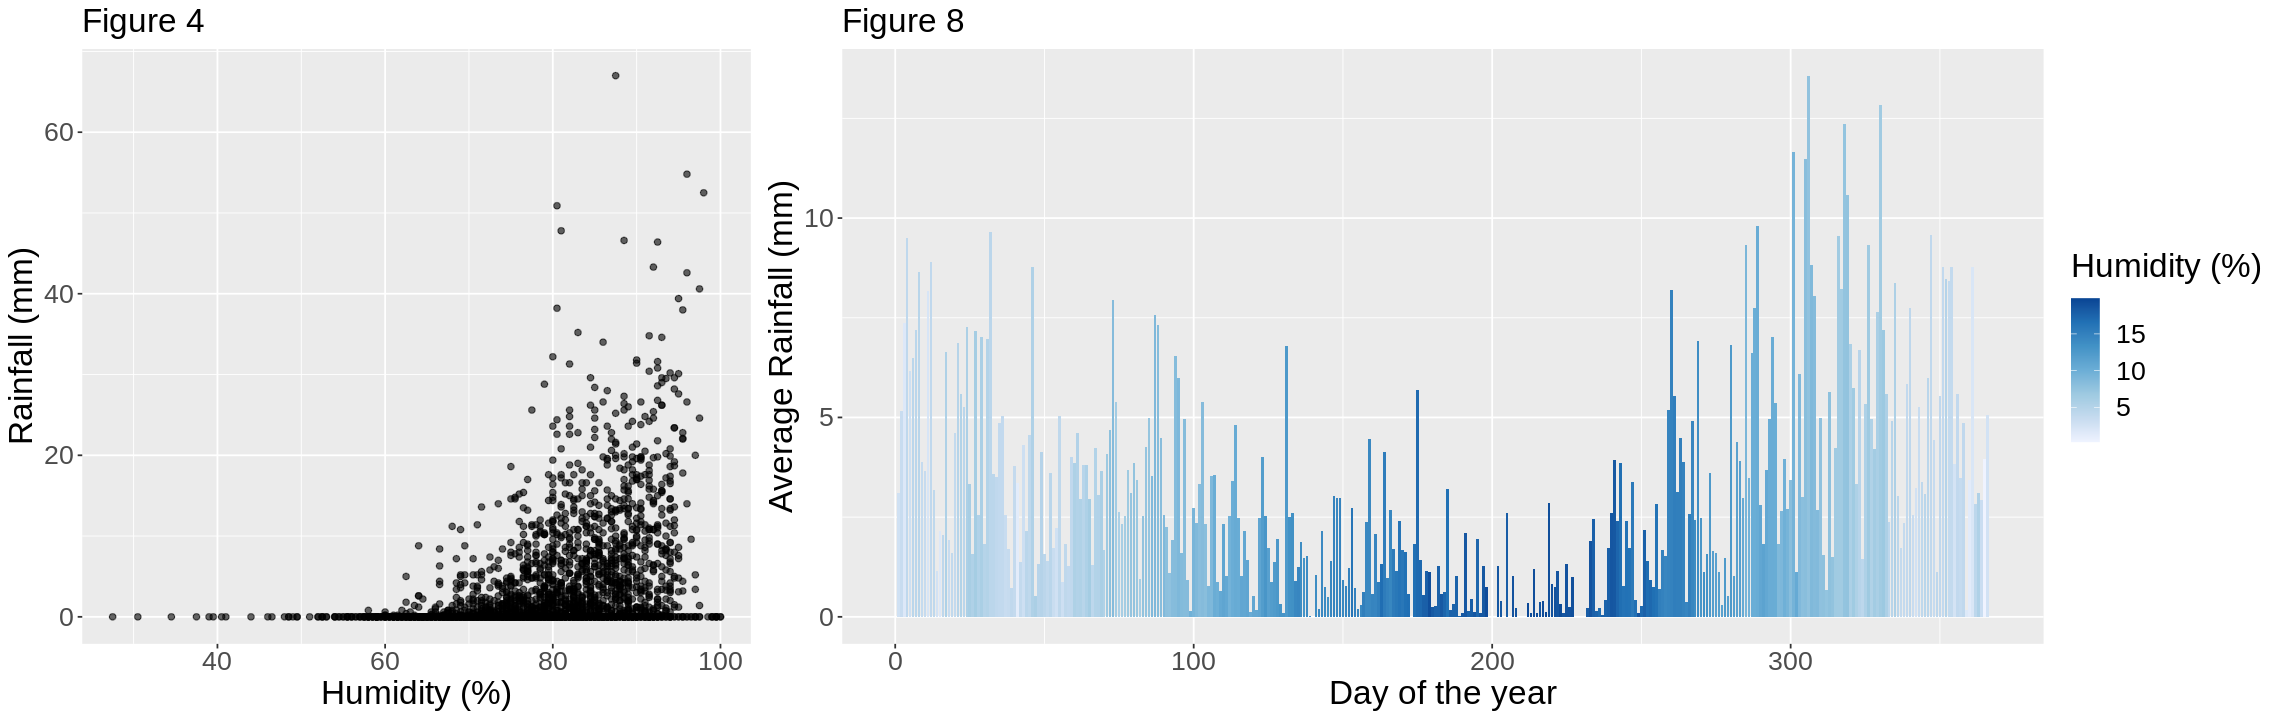

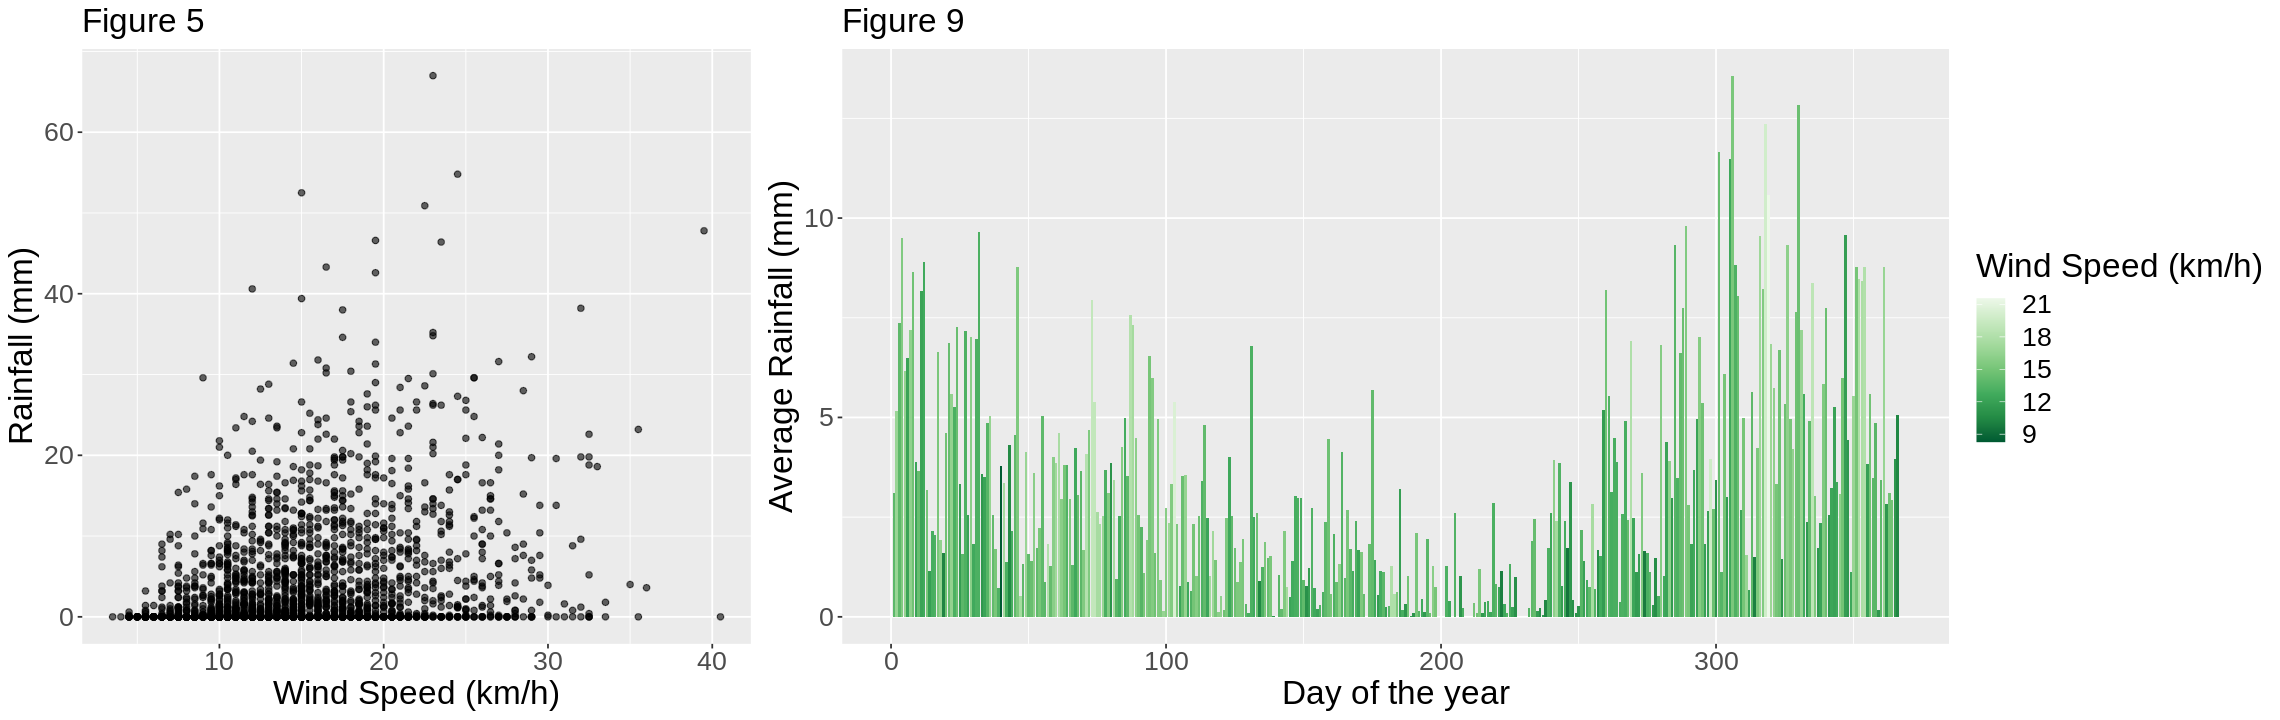

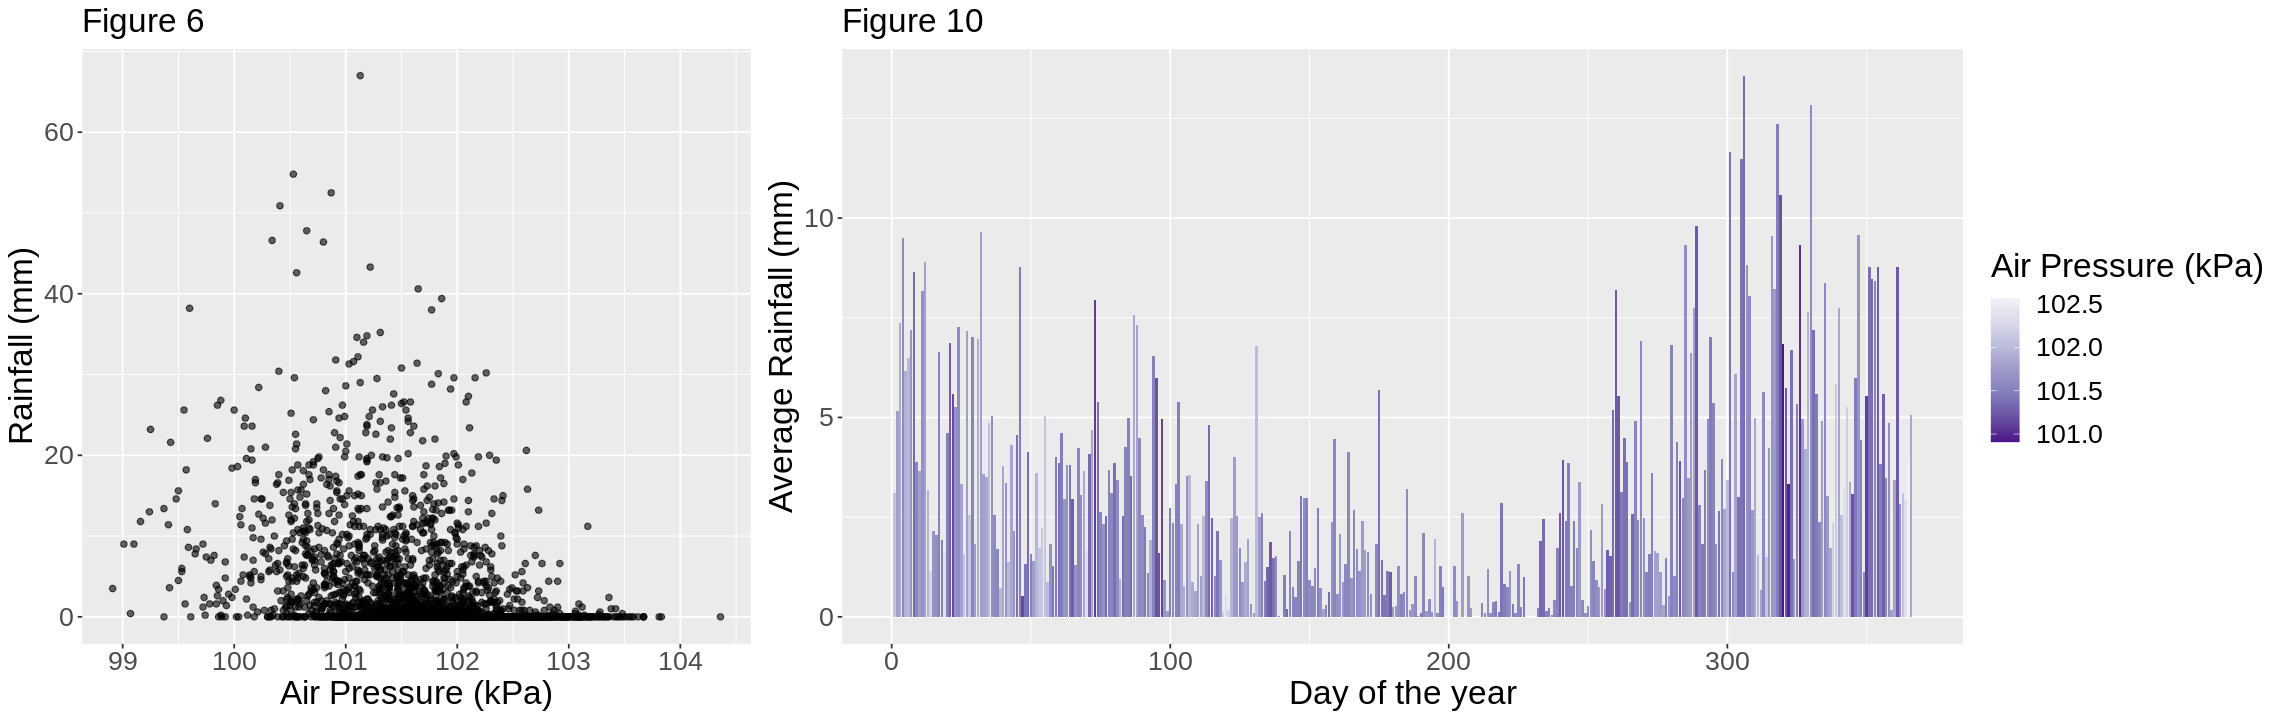

In [54]:
rain_temperature <- plot_grid(p1 = rain_temperature_plot, p2 = rain_temperature_over_time_plot, rel_widths = c(1, 2))
rain_temperature
rain_humidity <- plot_grid(p1 = rain_humidity_plot, p2 = rain_humidity_over_time_plot, rel_widths = c(1, 2))
rain_humidity
rain_wind <- plot_grid(p1 = rain_windspeed_plot, p2 = rain_windspeed_over_time_plot, rel_widths = c(1, 2))
rain_wind
rain_pressure <- plot_grid(p1 = rain_pressure_plot, p2 = rain_pressure_over_time_plot, rel_widths = c(1, 2))
rain_pressure

It is visible that all these values have relationships with rainfall, and their change with time is visible too. We now have a good set of predictor variables for our regression model: `yday + avg_temperature + avg_relative_humidity + avg_wind_speed + avg_pressure_station`. These correspond to the day of the year, and the measurements for temperature, relative humidity, wind speed, and pressure.

### Prediction using _KNN_

We will be predicting the amount of rainfall in millimetres using the $K$-Nearest Neighbors regression algorithm. Since the shapes of the plots for the predictors aren’t straight lines, we can’t use linear regression. KNN, which works doesn't require any specific shape, would be the logical choice for this model. The algorithm would take in given measurements of temperature, relative humidity, wind speed, and pressure, as well as the day of the year. It would then virtually "plot" this point in a 5-dimensional space, and calculate the distance between this and existing points from our training dataset, using the formula below. The predicted rainfall is then the average rainfall of the _k_ closest neighbors.

### ⚠ TODO: FORMULA HERE

One potential disadvantage of the KNN algorithm is that it doesn’t work very well when extrapolating data. One may hence argue that our model might not make accurate predictions for dates further in the future. However, we have solved this problem by wrangling the date predictor into `yday`, which represents the day of the year. The timescale therefore becomes ‘cyclic’, and no extrapolation is required.

Our model will be trained using our training dataset, which we have already split from the original above. We must then scale and center our predictors' values to ensure each predictor has an equal weighting on the prediction. To pick a value of $k$, we will use a 10-fold cross validation process and compare the root mean squared error for various values of $k$. We chose to use 10 folds because it is a reasonable balance between the $RMPSE$ values we get and the amount of time we have to carry out our project.

Once we train our model using our chosen $k$ value, we will use it to predict the rainfall values using the predictor variables in our _testing_ dataset. We will compare our predictions to the actual values to obtain the root mean squared predicted error ($RMSPE$) of our model. We will visualize our results using a line graph of _predicted_ values, layered on a scatterplot of the actual rainfall values against the day of the year. We can also produce further such plots for each of our predictor variables, to get a better understanding of where our model performed well and where it didn't.

### Expected Outcomes and Significance


The outcome we aim to achieve is an accurate regression model for predicting the rainfall amount for any given day of the year. 
This exploration could potentially also shed light on the effects of Climate Change in Vancouver, following events such as 2021 [atmospheric river](https://www.uvic.ca/news/topics/2022+bc-floods-and-climate-change+news#:~:text=The%20powerful%20atmospheric%20river%20that,disaster%20in%20the%20province's%20history.) that caused severe flooding in many parts of the coast. If we notice our model begins to be **more inaccurate** in the coming years, this could further prove this impact of climate change. 
If our model is accurate, it could be a step in replacing the expensive numerical methods of weather forecasting used today, saving on computing power, and indirectly, fossil fuel usage.

Since we know how we can assess how well our model predicts the value of rainfall, we'll then use R to perform cross-validation and to choose the optimal **K**.


### Training our Model

First, we will create a recipe `rain_recipe` for preprocessing our data. But as we have four predictors, we need to set all predictors at the same scales.

In [56]:
rain_recipe <- recipe(rain ~ yday + avg_temperature + avg_relative_humidity + avg_wind_speed + avg_pressure_station,
                      data = rain_training) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

Next, we create a model specification for K-nearest neighbors regression. We use `set_mode("regression")` as it essentially tells `tidymodels` that we need to use different metrics for tuning and evaluation (T.-A. Timbers et al.). 

In [57]:
rain_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

Then, we create the 10-fold cross-validation object `rain_vfold`, and put the recipe as well as model specification together in a workflow. Next we run cross-validation for a grid of numbers of neighbors ranging from 1 to 100 as well as tuning the model and returning the $RMSPE$ for each number of neighbors.

In [58]:
rain_vfold <- vfold_cv(rain_training, v = 10, strata = rain)

gridvals <- tibble(neighbors = seq(1, 100))

rain_results <- workflow() |> 
    add_recipe(rain_recipe) |> 
    add_model(rain_spec) |>
    tune_grid(resamples = rain_vfold, grid = gridvals) |> 
    collect_metrics()

Let us now visualizes how the $RMSPE$ varies with the number of neighbors **K**.

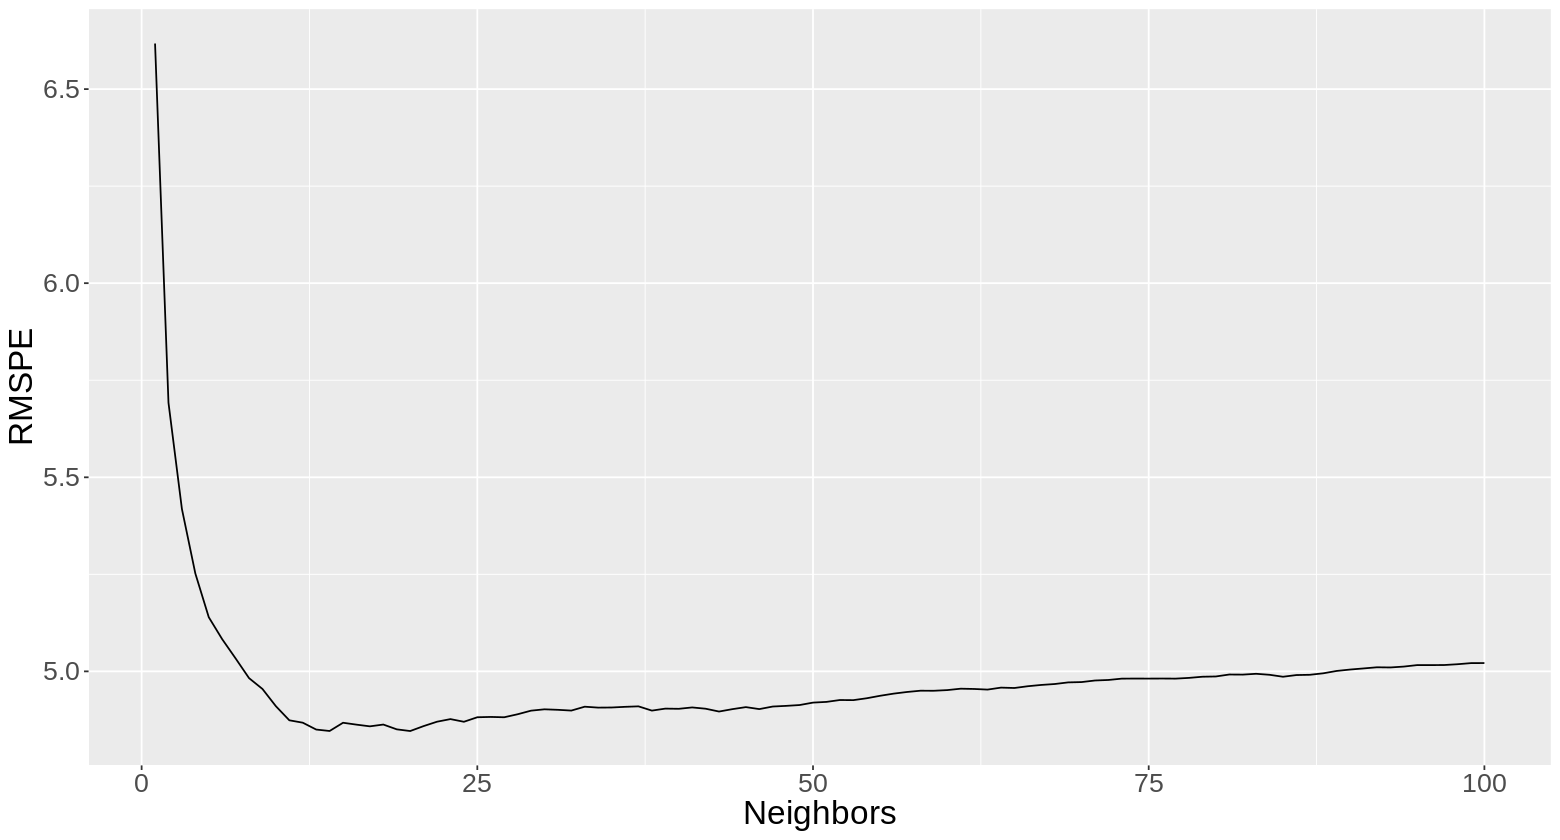

In [59]:
options(repr.plot.width = 13, repr.plot.height = 7)

rain_results <- rain_results |> filter(.metric == "rmse")
rain_results_plot <- ggplot(rain_results, aes(x = neighbors, y = mean)) +
                        geom_line() +
                        labs(x = "Neighbors", y = "RMSPE") +
                        theme(text = element_text(size = 20))
rain_results_plot

We can see that there don't appear to be any lucky spikes, so we shall take the value of k that gave the minimum $RMSPE$. 

The smallest occurs when **K** = 14.

In [60]:
k_min <- rain_results |>
            arrange(mean) |>
            head(1) |>
            select(neighbors) |>
            pull()
k_min

[1] 20

To predict on unseen data in the future, we first re-train our KNN regression model on the entire training data set, using **K** = 14 neighbors. Then we will use `predict` to make predictions on the test data.

In [61]:
rain_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

rain_best_fit <- workflow() |>
         add_recipe(rain_recipe) |>
         add_model(rain_best_spec) |>
         fit(data = rain_training)

rain_pred <- rain_best_fit |>
          predict(rain_testing) |>
          bind_cols(rain_testing)
          
head(rain_pred)

.pred,date,avg_hourly_temperature,avg_temperature,avg_hourly_relative_humidity,avg_relative_humidity,avg_hourly_dew_point,avg_dew_point,avg_hourly_wind_speed,avg_wind_speed,⋯,avg_hourly_health_index,avg_health_index,avg_hourly_cloud_cover_4,avg_cloud_cover_4,avg_hourly_cloud_cover_8,avg_cloud_cover_8,avg_hourly_cloud_cover_10,avg_cloud_cover_10,rain,yday
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.130,2011-01-01,-1.62,-1.55,76.1,74.0,-5.5,-5.5,1.58,5.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.0,1
0.435,2011-01-02,-1.08,-1.30,82.6,81.5,-3.7,-3.5,4.42,9.5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.0,2
9.085,2011-01-05,3.39,3.55,92.6,92.0,2.3,2.5,18.12,19.5,⋯,2.7,2.5,NA,NA,NA,NA,NA,NA,23.8,5
5.510,2011-01-08,3.45,2.95,83.1,83.0,0.9,0.8,20.88,19.5,⋯,2.1,2.5,NA,NA,NA,NA,NA,NA,0.0,8
0.320,2011-01-22,5.79,5.20,84.8,84.0,3.4,3.0,7.71,8.5,⋯,2.2,2.5,NA,NA,NA,NA,NA,NA,0.4,22
5.955,2011-01-24,6.84,6.90,94.0,93.5,5.9,5.8,12.17,13.0,⋯,2.5,2.5,NA,NA,NA,NA,NA,NA,30.4,24


### Results and Discussion

Finally, we use the `metrics` funciton to complete the summary of regression quality.

In [62]:
rain_summary <- rain_pred |>
                metrics(truth = rain, estimate = .pred)
rain_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.6144403
rsq,standard,0.4642597
mae,standard,2.4468492


We can see that our $RMSPE$ value is ~4.89 mm of rainfall. This is decent; considering that rainfall can range from 0 to even 40 mm, 4.89 mm isn't too high. However, rainfall is a dynamic thing, and varies throughout the year, so the $RMSPE$ value alone isn't a great indicator of our model's accuracy. 

Instead, let's see how accurately our final model has performed through the timespan of this dataset's observations. Since visualizing the entire timespan on one plot would make it very hard to see details, we shall visualize this separately for 2014 and 2019. These two years had the highest and lowest total rainfall in our dataset's timespan, as seen in our first table.

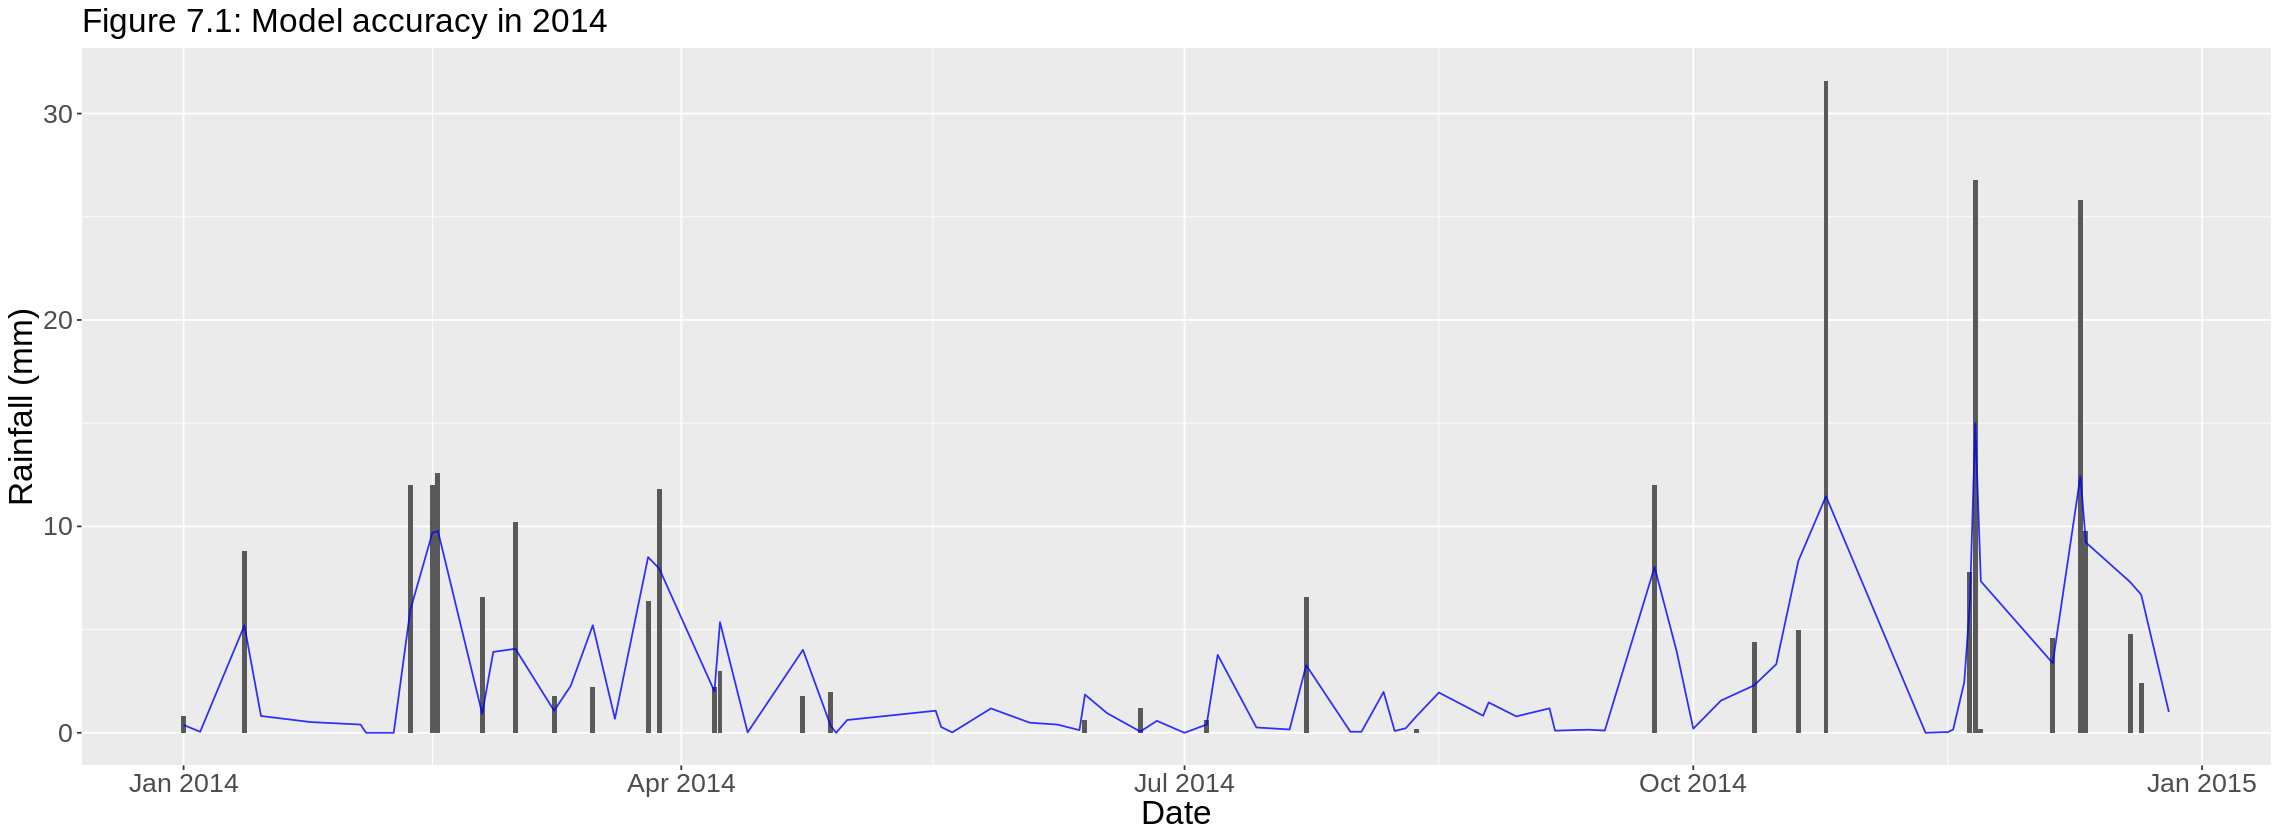

In [140]:
options(repr.plot.width = 19, repr.plot.height = 7)

skyblue <- "skyblue"

rain_pred_plot <- ggplot(filter(rain_pred, year(date) == 2014)) + 
                        geom_bar(stat = "identity", aes(x = date, y = rain)) +
                        geom_line(aes(x = date, y = .pred), color = "blue", alpha = 0.8) +
                        labs(x = "Date", y = "Rainfall (mm)", alpha = "Legend", subtitle = "Figure 7.1: Model accuracy in 2014") +
                        #scale_x_date(date_labels = "%B", date_breaks = "1 month") +
                        theme(text = element_text(size = 20))
rain_pred_plot

In the above visualization, we compare our predicted output (blue line) to the bar plot of actual rainfall for each day. We can see from the above visualization that our model does a good job at capturing general trends in rainfall - the shape of the blueline seems to closely follow that of the bars. However, we notice that for days with very high amounts of rainfall, our model repeatedly underpredicts. This means that while our model could be a general indicator, it may fail to give storm warnings when needed, so it may not be good enough to fully replace conventional weather prediction methods. Another limitation of our current model is that it does not consider other forms of precipitation, such as snow. If the predicted rainfall is 0 mm, it may be a snow day. 

### Future Prospects

Given the dynamic nature of the weather, it is worth considering the possibility of our model becoming more inaccurate over time. This could indicate that rain values are adhering less to weather conforms, and suggest the effect of climate change in Vancouver. Let us visualize the change in our $RMSPE$ over time, to see how our model's accuracy is changing.

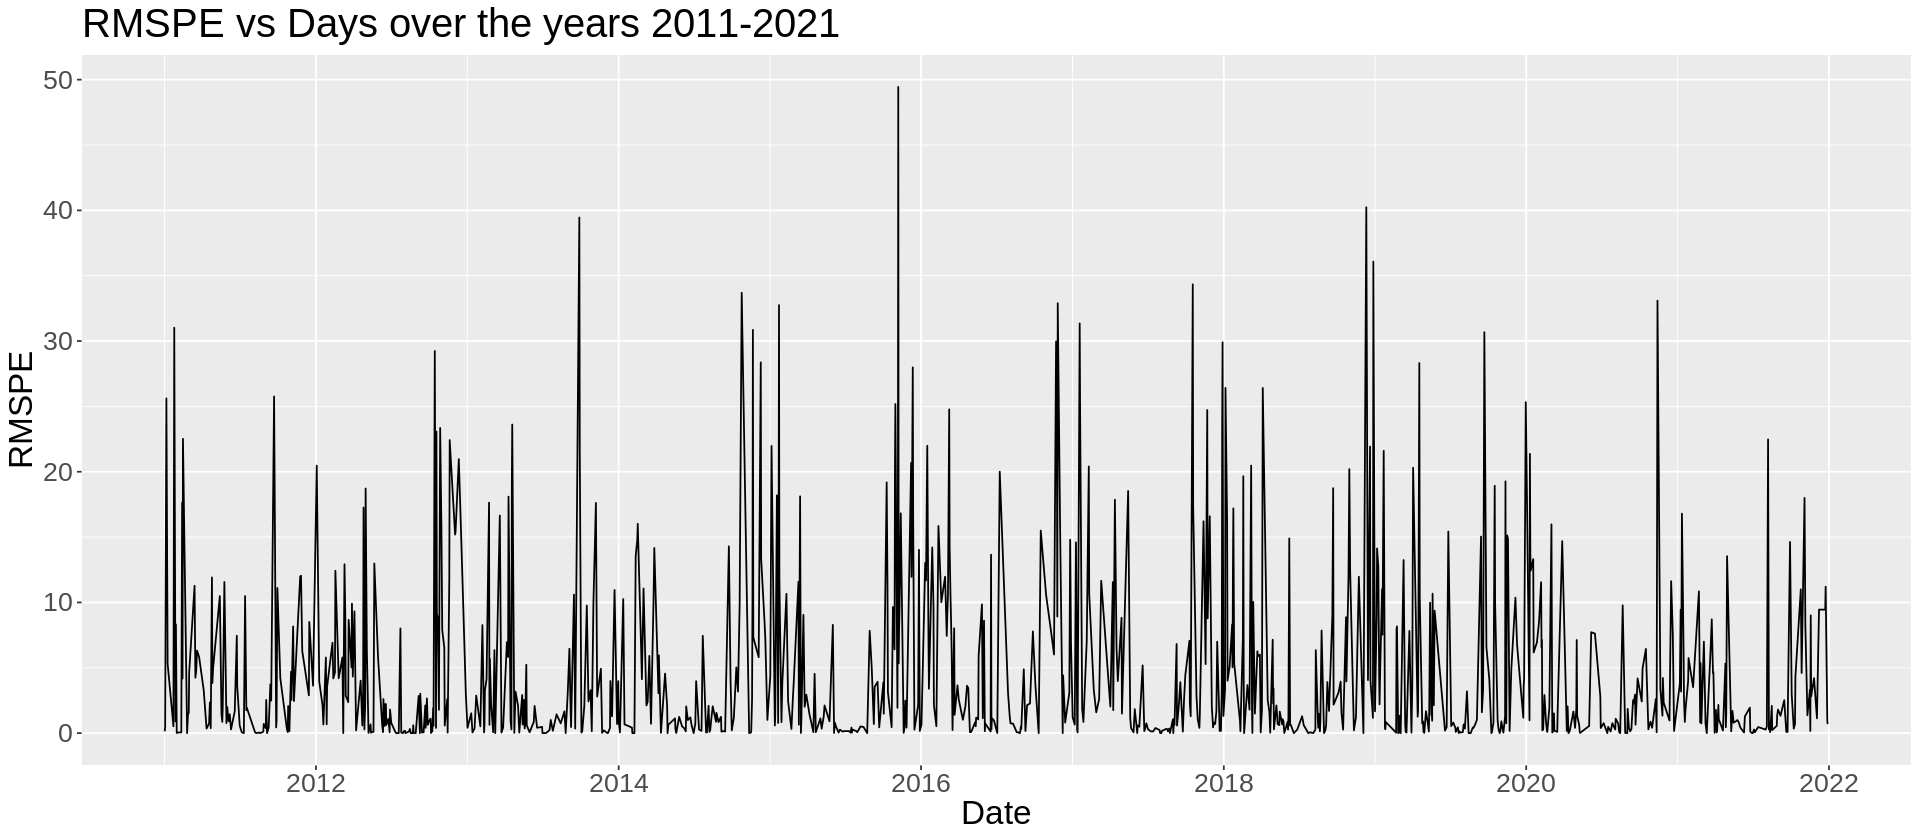

In [23]:
climate_change <- rain_pred |>
                    mutate(rmspe = sqrt((.pred)^2 + rain^2)) |>
                    select(date, rmspe)
                    
                    
climate_change_plot <-climate_change |>
                        ggplot(aes(x = date, y = rmspe)) +
                        geom_line() +
                        labs(x = "Date", y = "RMSPE") +
                        theme(text = element_text(size = 20)) +
        ggtitle("RMSPE vs Days over the years 2011-2021") 

climate_change_plot


We can see that the highest $RMSPE$, i.e. the greatest error was made in 2022, which is known to be a year with very strange, anomalous rainfall patterns so far. However, this graph is too noisy for us to interpret more. Let us instead plot the change of average $RMSPE$ for each year.

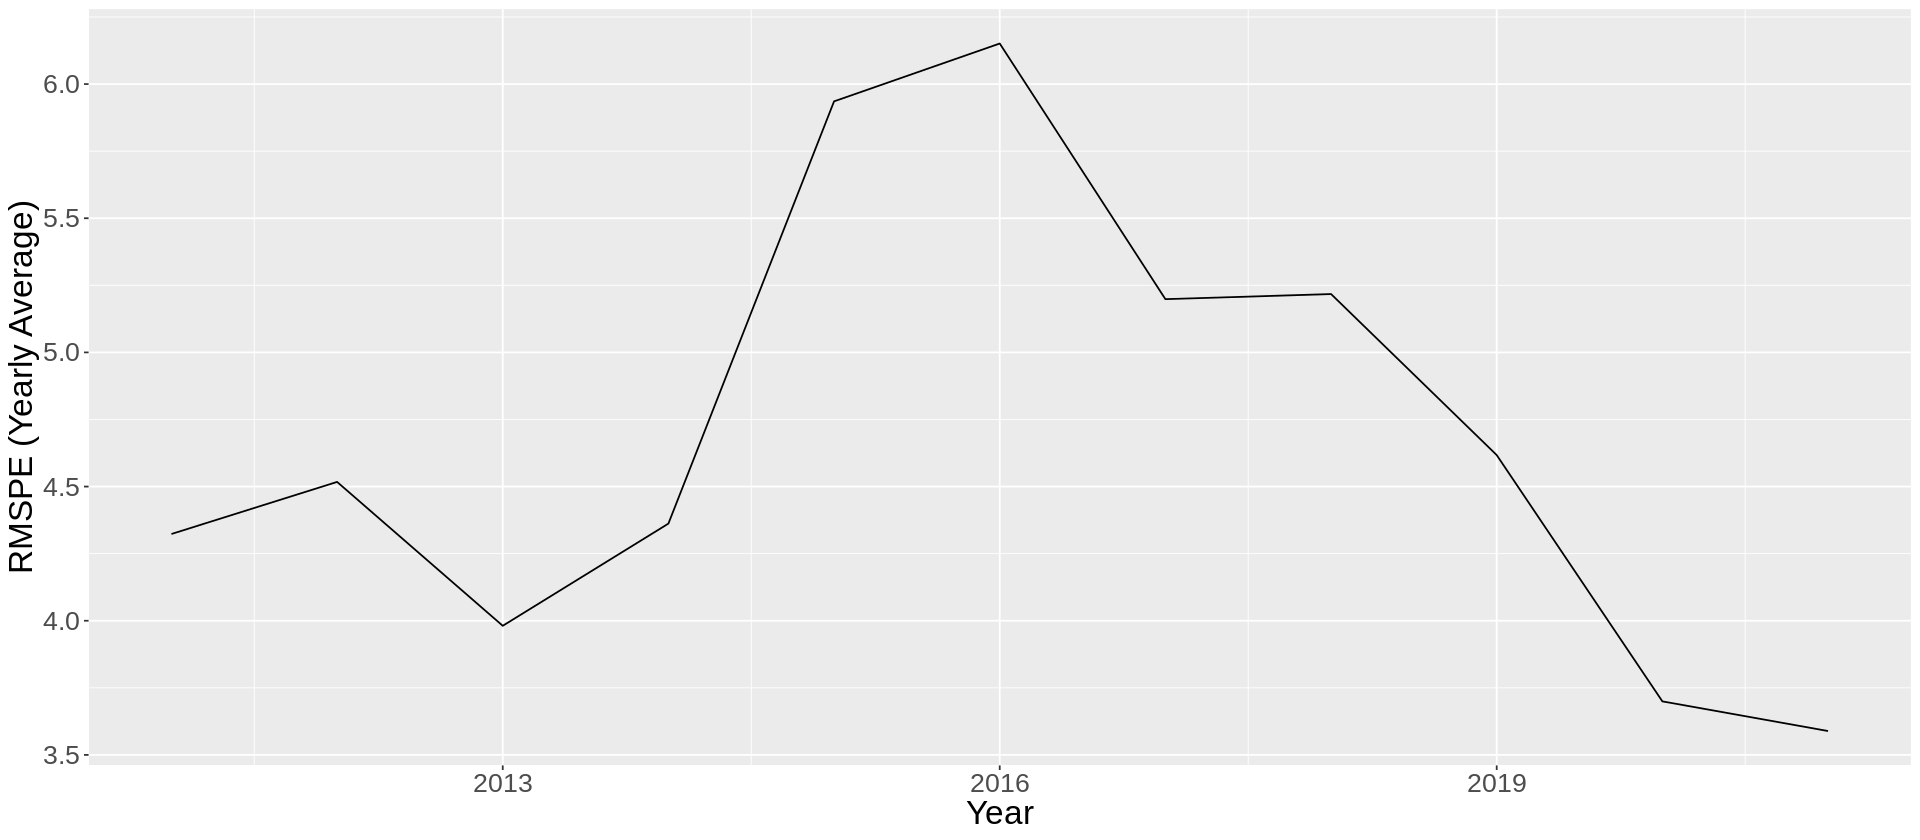

In [24]:
climate_change_yearly_plot <-climate_change |>
                        group_by(year(date)) |>
                        summarize(rmspe = mean(rmspe)) |>
                        ggplot(aes(x = `year(date)`, y = rmspe)) +
                        geom_line() +
                        labs(x = "Year", y = "RMSPE (Yearly Average)") +
                        theme(text = element_text(size = 20))
climate_change_yearly_plot

Here, it is visible that the most inaccurate years for our model's predictions, on average, were 2014 and 2016. The average $RMSPE$ values have decreased after that, with an interesting zig-zag pattern is visible. There is no clear increase in accuracy, however, so we can't attribute the inaccuracy to climate change. This, however, isn't conclusive evidence to _deny_ climate change either. Also, note: 2022 isn't over yet, and this dataset only contains observations up to October?. The values could change once we obtain the complete dataset for 2022.

Back to our research question, we wanted to consider whether machine learning based models could replace conventional expensive numerical models for weather prediction. The very fact that our model was able to succesfully capture patterns in the rainfall is a good sign. Since this model was made using KNN Regression (one of the simplest regression algorithms) and still got a decent $RMSPE$, this gives a promising sign of achieving even better accuracies with even more complex regression algorithms.
Our results indicate that there is great potential for machine learning in meteorology, and soon, we could be replacing old, slow, expensive methods with faster and more affordable machine learning models.

   ### Works Cited 

Hill, Russ Schumacher and Aaron. “AI and Machine Learning Are Improving Weather Forecasts, but They Won’t Replace Human Experts.” Colarado State University, 26 May 2022, https://source.colostate.edu/ai-and-machine-learning-are-improving-weather-forecasts-but-they-wont-replace-human-experts/.

National Oceanic and Atmospheric Administration. “Weather Observations.” NOAA, 1 Feb. 2011, www.noaa.gov/education/resource-collections/weather-atmosphere/weather-observations#:~:text=Temperature%2C%20humidity%2C%20precipitation%2C%20air.

Vancouver Weather Stats. “Data Download for Vancouver.” Amateur Weather Statistics for Vancouver, British Columbia, https://vancouver.weatherstats.ca/download.html.

Timbers, Tiffany-Anne, et al. Data Science : An Introduction. Boca Raton, Crc Press, 2022.